In [1]:
# !pip install kagglehub

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

import numpy as np

# 1.1. Importă setul de date
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 1.2. Normalizează datele (valorile între 0 și 1)
x_train = x_train / 255.0
x_test = x_test / 255.0

# 1.3. Dacă este necesar, adaugă un canal suplimentar pentru imagini grayscale
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")


x_train shape: (60000, 28, 28, 1), y_train shape: (60000,)


PCA Features Shape: (60000, 10)


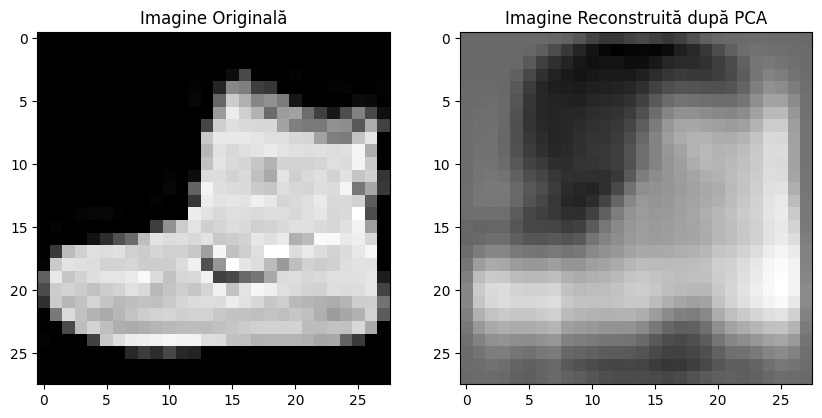

In [ ]:
def apply_pca_tf(images, n_components=50):
    # Aplatizează imaginile
    images_flattened = tf.reshape(images, (images.shape[0], -1))
    # Centralizează datele
    mean = tf.reduce_mean(images_flattened, axis=0)
    images_centered = images_flattened - mean
    # Calculăm SVD
    s, u, v = tf.linalg.svd(images_centered)
    # Selectăm primele componente principale
    pca_features = tf.matmul(images_centered, v[:, :n_components])
    return pca_features, v

# Aplică PCA pe setul de antrenare
pca_features_train, v_train = apply_pca_tf(x_train)
pca_features_test, v_test = apply_pca_tf(x_test)
print(f"PCA Features Shape: {pca_features_train.shape}")

# Afișează o imagine originală și imaginea după aplicarea PCA
import matplotlib.pyplot as plt

# Selectăm o imagine din setul de antrenare
original_image = x_train[0].squeeze()

# Reconstruim imaginea din caracteristicile PCA
reconstructed_image_flat = tf.matmul(pca_features_train[0:1], tf.transpose(v_train[:, :pca_features_train.shape[1]])).numpy()
reconstructed_image = reconstructed_image_flat.reshape(original_image.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Imagine Originală")

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Imagine Reconstruită după PCA")
plt.show()

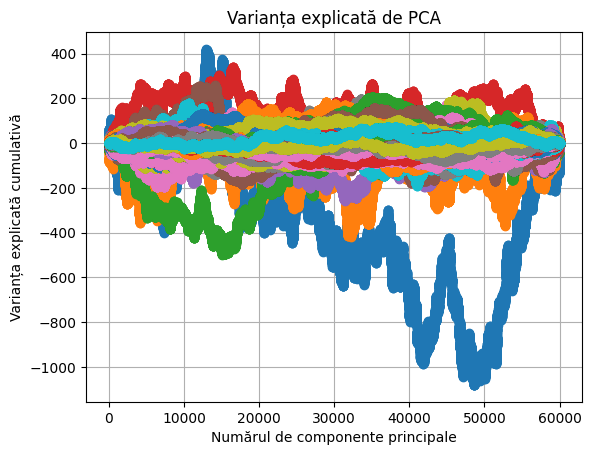

In [ ]:
import matplotlib.pyplot as plt

# Grafic varianță explicată cumulativ
cumulative_variance = np.cumsum(pca_features_train.numpy(), axis=0)
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Numărul de componente principale')
plt.ylabel('Varianța explicată cumulativă')
plt.title('Varianța explicată de PCA')
plt.grid()
plt.show()


In [ ]:
import cv2
# from skimage.feature import hog

# def apply_hog_tf(images):
#     hog_features = []
#     for img in images:
#         # Dacă imaginea este TensorFlow tensor, convertește-o în NumPy
#         if isinstance(img, tf.Tensor):
#             img_np = img.numpy().squeeze()  # Elimină dimensiunile redundante
#         else:
#             img_np = img.squeeze()  # Direct pentru NumPy
#         # Extragere HOG
#         feature, _ = hog(img_np, orientations=9, pixels_per_cell=(8, 8),
#                          cells_per_block=(2, 2), visualize=True)
#         hog_features.append(feature)
#     return tf.convert_to_tensor(hog_features, dtype=tf.float32)


# # Aplică HOG pe un subset de date
# hog_features_train = apply_hog_tf(x_train[:1000])
# hog_features_test = apply_hog_tf(x_test[:1000])
# print(f"HOG Features Shape: {hog_features_train.shape}")



from skimage.feature import hog

def apply_hog_fixed(images):
    hog_features = []
    for img in images:
        # Elimină dimensiunile redundante
        img_np = img.squeeze()  # Funcționează indiferent de TensorFlow sau NumPy
        # Extragere HOG
        feature, _ = hog(img_np, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True)
        hog_features.append(feature)
    return np.array(hog_features)

# Aplică HOG pe un subset de date
hog_features_train = apply_hog_fixed(x_train[:1000])
hog_features_test = apply_hog_fixed(x_test[:1000])
print(f"HOG Features Shape: {hog_features_train.shape}")



HOG Features Shape: (1000, 144)


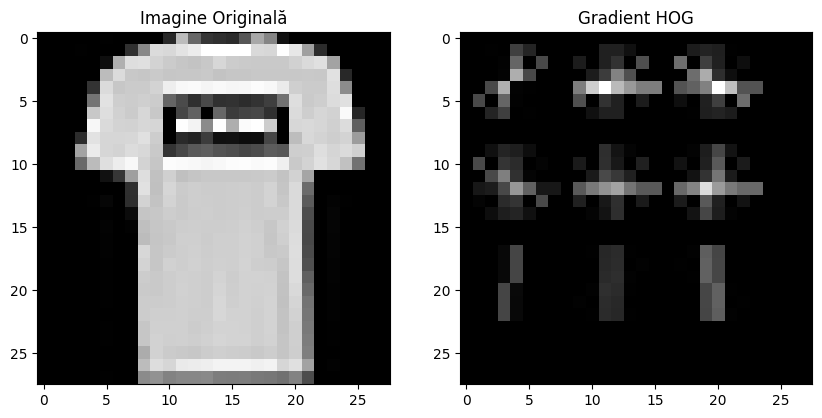

In [ ]:
# Afișează gradientul HOG pentru o imagine
import matplotlib.pyplot as plt
from skimage.feature import hog

image_sample = x_train[1].squeeze()
_, hog_image = hog(image_sample, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_sample, cmap='gray')
plt.title("Imagine Originală")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("Gradient HOG")
plt.show()


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\raduf\.cache\kagglehub\datasets\moltean\fruits\versions\11


In [ ]:
import tensorflow as tf

# Specifică calea către datele descărcate
train_dir = f"{path}/fruits-360_dataset_100x100/fruits-360/Training"
test_dir = f"{path}/fruits-360_dataset_100x100/fruits-360/Test"


# Creează dataset-urile
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='int',  # Etichete numerice
    image_size=(32, 32),  # Fruits-360 are imagini mici
    batch_size=32
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    image_size=(32, 32),
    batch_size=32
)

# Normalizează datele la [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 70491 files belonging to 141 classes.
Found 23619 files belonging to 141 classes.


In [ ]:
from skimage.color import rgb2gray
from skimage.feature import hog

# Conversia în grayscale
train_images_gray = np.array([rgb2gray(img) for img in train_images])
test_images_gray = np.array([rgb2gray(img) for img in test_images])

# Aplică HOG
def apply_hog(images):
    hog_features = []
    for img in images:
        feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False)
        hog_features.append(feature)
    return np.array(hog_features)

train_hog = apply_hog(train_images_gray)
test_hog = apply_hog(test_images_gray)

print("Dimensiunea setului de antrenare după HOG:", train_hog.shape)


NameError: name 'train_images' is not defined